# Weighted Link Prediction w/ Uncertainty using cuGraph and the Epinions Trust Network Dataset

This notebook builds a binary nearest neighbor classifier using a weighted average of the weighted jaccard similarity measure, where the labels of the closer neighbors are weighted more heavily. A hyper-parameter is provided to trade-off the influence of labels from very distant vertices. The weighted average is passed through a sigmoid function and used as a classifier to predict the likelihood of trust, or distrust, between vertices.

In [1]:
import cugraph
import cuml
import cudf

import numpy as np

import matplotlib.pyplot as p

%matplotlib inline

In [2]:
dataset_path = "../data/epinions.txt"

In [3]:
%%time
gdf = cudf.read_csv(dataset_path, sep="\t", header=0, names=["src", "dst", "trust"], dtype=["int32", "int32", "float32"]).fillna(0)

CPU times: user 392 ms, sys: 768 ms, total: 1.16 s
Wall time: 1.15 s


The data represents a social network graph from source users to destination users with weights `-1` for untrusted and `1` for trusted

In [4]:
%%time
gdf.head()

CPU times: user 100 ms, sys: 28 ms, total: 128 ms
Wall time: 133 ms


,src,dst,trust
0,0,1,-1.0
1,1,128552,-1.0
2,2,3,1.0
3,4,5,-1.0
4,4,155,-1.0


First, we want to get a feel for the distribution of the trust labels. The labels are not represented evenly across our dataset. There are almost twice as many positive labels are negative labels. 

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 23.2 ms


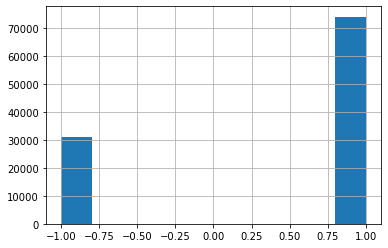

In [5]:
%%time
gdf["trust"].to_pandas().hist()

Let's now look at the distribution of the labels among the vertices. We can see we have some vertices with 

In [6]:
%%time
gdf.groupby(["src", "trust"]).count().reset_index().rename({"dst":"count"}).sort_values("count", ascending=False)

CPU times: user 152 ms, sys: 40 ms, total: 192 ms
Wall time: 232 ms


,src,trust,count
189,167,1.0,1893
371,321,1.0,1776
408,353,1.0,1740
2086,1652,-1.0,1562
1178,966,-1.0,1217
774,655,-1.0,1193
1366,1118,-1.0,1137
2120,1682,-1.0,1120
1033,852,1.0,1017
23,20,1.0,967


Build a cuGraph using the edge lists and weights from our cuDF

In [7]:
%%time
G = cugraph.Graph()
G.add_edge_list(gdf.src, gdf.dst, gdf.trust)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 5.9 ms


Since our graph is bipartite, we will want to use the two-hop neighborhoods for computing our Jaccard similarity weights. 

In [8]:
%%time
two_hop = G.get_two_hop_neighbors()

CPU times: user 20 ms, sys: 24 ms, total: 44 ms
Wall time: 44.5 ms


Construct a search list to compute the Jaccard similarity for a given source vertex to all other destination vertices

In [9]:
%%time
new_gdf = cudf.DataFrame()
new_gdf["second"] = gdf.dst.unique().astype("int32")

CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 465 ms


In [10]:
%%time
new_gdf["first"] = 61
new_gdf.first = new_gdf.first.astype("int32")

CPU times: user 120 ms, sys: 12 ms, total: 132 ms
Wall time: 209 ms


Compute Jaccard similarities and weight by the pagerank scores. This will put a higher weight on nodes that are more influential in the network. 

In [11]:
%%time
jacc = cugraph.jaccard_w(G, cugraph.pagerank(G)["pagerank"], new_gdf.first, new_gdf.second)

CPU times: user 64 ms, sys: 28 ms, total: 92 ms
Wall time: 99.3 ms


Join our jaccard weights with our original cuDF so that we can explore the relationships

In [12]:
%%time
gdf2 = cudf.merge(jacc, gdf, left_on="destination", right_on="src", how="left")

CPU times: user 60 ms, sys: 20 ms, total: 80 ms
Wall time: 76.8 ms


Drop unused columns that resulted from the join

In [13]:
%%time
gdf2 = gdf2.drop(["source", "destination"])

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.74 ms


Sort our new cuDF in descending order by the Jaccard similarities to get a feel for the vertices that are similar to our query vertex

In [14]:
%%time
gdf2.sort_values("jaccard_coeff", ascending=False)

CPU times: user 112 ms, sys: 52 ms, total: 164 ms
Wall time: 208 ms


,jaccard_coeff,src,dst,trust
1068,1.000000,61,321,1.0
71729,1.000000,1257,321,1.0
100927,1.000000,1846,321,1.0
33059,0.884775,1405,321,1.0
33090,0.884775,1405,1406,1.0
16124,0.821978,583,321,1.0
16154,0.821978,583,584,1.0
436,0.818677,320,321,1.0
468,0.818677,320,6800,1.0
43240,0.812159,1126,321,1.0


Since the cuDF above shows mostly trusted nodes, query some untrusted nodes as a sanity check

In [15]:
%%time
gdf2[gdf2.trust == -1.0].head()

CPU times: user 304 ms, sys: 40 ms, total: 344 ms
Wall time: 370 ms


,jaccard_coeff,src,dst,trust
0,0.0,1451,98037,-1.0
4,0.0,1455,7,-1.0
7,0.0,1458,20374,-1.0
11,0.0,1462,865,-1.0
29,0.0,1481,25,-1.0


Let's take a random destination vertex and look at the distribution of trust compared to the Jaccard weights. Based on similar vertices, it appears that we would want to weight distrusting this node higher than trusting it. 

In [16]:
%%time
gdf2[gdf2.dst==852].sort_values("jaccard_coeff", ascending=False)

CPU times: user 24 ms, sys: 24 ms, total: 48 ms
Wall time: 47.9 ms


,jaccard_coeff,src,dst,trust
84227,0.006323,1682,852,-1.0
118760,0.004857,1652,852,-1.0
69815,0.000000,1325,852,1.0


We can compute a weighted average so that we can quantify our uncertainty. Just computing a simple weighted average would give no influence from the global view, since Jaccard weights of the most distant vertices are `0.0`. To give them some low level of influence, let's choose some parameter gamma, which we can add to all the weights, to allow a trade-off between local and global influence. Let's set it to the lowest Jaccard weight - `1e-3`

In [17]:
%%time
gamma = gdf2[gdf2.jaccard_coeff > 0.0].jaccard_coeff.min() - 0.001

CPU times: user 48 ms, sys: 24 ms, total: 72 ms
Wall time: 73.1 ms


In [18]:
gamma

0.0030643285028636455

Define a simple function to loop through our local and global neighborhoods around a destination vertex and compute the weighted average, adjusted by gamma. 

In [19]:
def compute_weighted_avg(jacc_series, trust_series):
    cur_sum = 0
    for i in range(len(jacc_series)):
        jacc = jacc_series[i]
        trust = trust_series[i]
        cur_sum += 10*((jacc+gamma)*trust)
        
        
    return cur_sum / len(jacc_series)

To better quantify uncertainty, we can map our resulting value to a sigmoid. Values closer to 0.5 will be less certain than values closer to 0.0 or 1.0. Notice we scale each weighted value in the sum above by 10 so that it better maps to the sigmoid. 

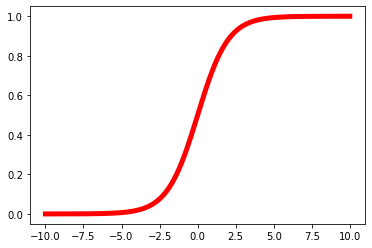

In [20]:
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

x = np.arange(-10, 10, .005)

S = sigmoid(x)

p.plot(x, S, color='red', lw=5)
p.show()

Define a simple function to classify the sigmoid of the weighted average as untrusted if it falls below the threshold of 0.5 and trusted otherwise. This initially assumes an unbiased distribution of classes, but `thres` can be adjusted accordingly based on actual bias of your dataset. 

In [21]:
def classify(x, thres=0.5):
    return -1.0 if sigmoid(x) < thres else 1.0

Now let's classify our destination vertex from above. We can see this classification has a low level of certainty (value is close to 0.5) since we have low Jaccard weights and conflicting trust labels. 

In [22]:
%%time
query_df = gdf2[gdf2.dst==852]

CPU times: user 40 ms, sys: 16 ms, total: 56 ms
Wall time: 55.1 ms


In [23]:
query_df

,jaccard_coeff,src,dst,trust
69815,0.000000,1325,852,1.0
84227,0.006323,1682,852,-1.0
118760,0.004857,1652,852,-1.0


In [24]:
%%time
val = compute_weighted_avg(query_df.jaccard_coeff, query_df.trust)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 3.11 ms


In [25]:
val

-0.047480855683485666

In [26]:
sigmoid(val)

0.48813201562533

In [27]:
classify(val)

-1.0

And choose another destination vertex to classify. We can see this vertex has a much higher certainty since the Jaccard weight is higher and there are no conflicting trust labels. 

In [28]:
%%time
query_df = gdf2[gdf2.dst==742]
query_df

CPU times: user 36 ms, sys: 20 ms, total: 56 ms
Wall time: 53.5 ms


,jaccard_coeff,src,dst,trust
8088,0.64184,740,742,1.0


In [29]:
%%time
val = compute_weighted_avg(query_df.jaccard_coeff, query_df.trust)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.82 ms


In [30]:
val

6.449040711633861

In [31]:
sigmoid(val)

0.9984204598215562

In [32]:
classify(val)

1.0

Now let's look at a destination vertex that contains both a high Jaccard weight and some conflicting labels in the global dissimilar vertices. 

In [33]:
%%time
query_df = gdf2[gdf2.dst==2643]
query_df

CPU times: user 20 ms, sys: 28 ms, total: 48 ms
Wall time: 48.9 ms


,jaccard_coeff,src,dst,trust
380,0.616696,1062,2643,1.0
1936,0.000000,423,2643,1.0
2020,0.000000,421,2643,1.0
2927,0.000000,700,2643,1.0
3273,0.000000,1459,2643,1.0
3595,0.066799,205,2643,1.0
6830,0.000000,689,2643,1.0
10904,0.000000,666,2643,1.0
11212,0.025272,1622,2643,1.0
14027,0.000000,717,2643,1.0


In [34]:
%%time
val = compute_weighted_avg(query_df.jaccard_coeff, query_df.trust)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 20.9 ms


In [35]:
val

0.2441755973489491

In [36]:
sigmoid(val)

0.5607424015898242

In [37]:
classify(val)

1.0

In [38]:
%%time
query_df.sort_values("jaccard_coeff", ascending=False)

CPU times: user 32 ms, sys: 20 ms, total: 52 ms
Wall time: 48.9 ms


,jaccard_coeff,src,dst,trust
380,0.616696,1062,2643,1.0
3595,0.066799,205,2643,1.0
11212,0.025272,1622,2643,1.0
75885,0.007077,1118,2643,-1.0
1936,0.000000,423,2643,1.0
2020,0.000000,421,2643,1.0
2927,0.000000,700,2643,1.0
3273,0.000000,1459,2643,1.0
6830,0.000000,689,2643,1.0
10904,0.000000,666,2643,1.0


We could lower gamma to reduce the global weight and put more weight on the local neighborhood of similar vertices. We can see here where that can have an impact on the classification result, when there is high uncertainty. If we set `gamma` to `0.0001` then we end up with a final classifiation of `-1`, since we have a Jaccard weight that is much higher than the others with a label of `-1`. If we increase the influence of more distance neighborhoods, by adjusting `gamma` to be `0.001`, the final classified label will be `1`

In [39]:
gamma = 0.001

In [40]:
%%time
query_df = gdf2[gdf2.dst==1481]
query_df.sort_values("jaccard_coeff", ascending=False)

CPU times: user 72 ms, sys: 28 ms, total: 100 ms
Wall time: 99.9 ms


,jaccard_coeff,src,dst,trust
96670,0.013826,1512,1481,-1.0
123836,0.004546,353,1481,1.0
125649,0.004064,167,1481,1.0
400,0.000000,1055,1481,1.0
2246,0.000000,1474,1481,1.0
3591,0.000000,251,1481,1.0
7664,0.000000,487,1481,1.0
16143,0.000000,553,1481,-1.0
21508,0.000000,1335,1481,1.0
22622,0.000000,1458,1481,1.0


In [41]:
%%time
val = compute_weighted_avg(query_df.jaccard_coeff, query_df.trust)

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 14.2 ms


In [42]:
val

0.0030443163314147993

In [43]:
sigmoid(val)

0.5007610784950562

In [44]:
classify(val)

1.0

Here's an example where we have Jaccard weights for all the source vertices in our voting committee, but since we have some neighbors with exact similarity, we are going to prioritize those labels much higher than the more distant neighbors.  

In [45]:
%%time
query_df = gdf2[gdf2.dst==321]

CPU times: user 40 ms, sys: 20 ms, total: 60 ms
Wall time: 55.5 ms


In [46]:
%%time
query_df.sort_values("jaccard_coeff", ascending=False)

CPU times: user 44 ms, sys: 4 ms, total: 48 ms
Wall time: 47.1 ms


,jaccard_coeff,src,dst,trust
1068,1.000000,61,321,1.0
71729,1.000000,1257,321,1.0
100927,1.000000,1846,321,1.0
33059,0.884775,1405,321,1.0
16124,0.821978,583,321,1.0
436,0.818677,320,321,1.0
43240,0.812159,1126,321,1.0
75280,0.754608,595,321,1.0
54752,0.710325,1200,321,1.0
22971,0.654320,915,321,1.0


In [47]:
%%time
val = compute_weighted_avg(query_df.jaccard_coeff, query_df.trust)

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 44.3 ms


In [48]:
val

2.3063480230818527

In [49]:
sigmoid(val)

0.9094014166928449

In [50]:
classify(val)

1.0